# Document classification

In [2]:
!pip list | grep tensorflow

tensorflow-estimator         2.7.0
tensorflow-gpu               2.7.0
tensorflow-io-gcs-filesystem 0.22.0


In [1]:
!nvidia-smi

Sat Dec 11 08:53:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   32C    P0    39W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import transformers

print(transformers.__version__)

4.12.5


In [2]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "sberbank-ai/ruRoberta-large"

batch_size = 8

## Dataset

In [50]:
import pandas as pd

training_columns=['path', 'text']
df = pd.read_excel(open('classifier.xlsx', 'rb'), sheet_name='good', index_col=0)
df = df[['documentType']+training_columns]
df.head()

,documentType,path,text
0,CONTRACT,ДД по практикам\Практика коммерческой логистик...,2.1. В соответствии с условиями настоящего Дог...
1,SUPPLEMENTARY_AGREEMENT,ДД по практикам\Практика коммерческой логистик...,_x000D_\n1. Внести изменение в п. 1.1 Договора...
2,CONTRACT,ДД по практикам\Практика коммерческой логистик...,"1.1. Перевозчик в порядке и на условиях, устан..."
3,CONTRACT,ДД по практикам\Практика коммерческой логистик...,_x000D_\n 1.1. Перевозчик в порядке и на усл...
4,CONTRACT,ДД по практикам\Практика коммерческой логистик...,2.1. В соответствии с настоящим Договором Испо...


In [51]:
len(df)

789

In [52]:
from pathlib import Path
import os

df['path'] = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[1])
df.head()


,documentType,path,text
0,CONTRACT,Практика коммерческой логистики,2.1. В соответствии с условиями настоящего Дог...
1,SUPPLEMENTARY_AGREEMENT,Практика коммерческой логистики,_x000D_\n1. Внести изменение в п. 1.1 Договора...
2,CONTRACT,Практика коммерческой логистики,"1.1. Перевозчик в порядке и на условиях, устан..."
3,CONTRACT,Практика коммерческой логистики,_x000D_\n 1.1. Перевозчик в порядке и на усл...
4,CONTRACT,Практика коммерческой логистики,2.1. В соответствии с настоящим Договором Испо...


In [53]:
df = df[df.apply(lambda row: not row['path'].startswith('Исключена'), axis=1)]

In [54]:
import pprint as pp
categories = df['path'].unique()
pp.pprint(sorted(categories))

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым '
 'имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']


In [55]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='png'


rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Text(0.5, 1.0, 'Количество текстов по темам')

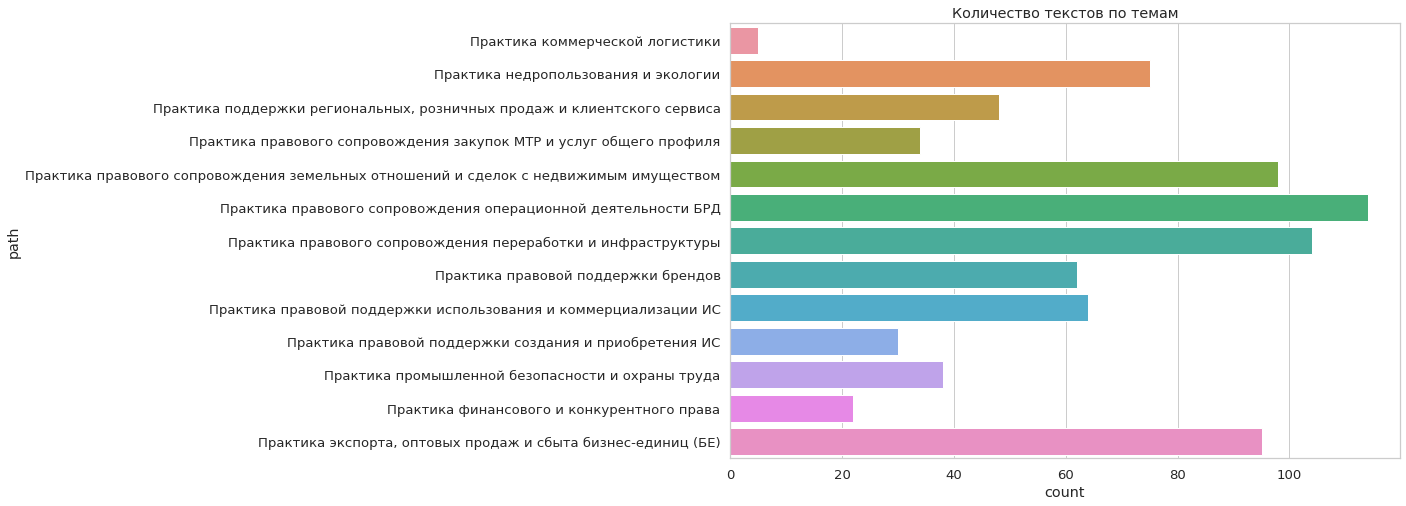

In [56]:
sns.countplot(data=df[training_columns], y='path')
plt.title("Количество текстов по темам")

In [57]:
df['text'][2]

'1.1. Перевозчик в порядке и на условиях, установленных настоящим Договором, обязуется за вознаграждение выполнить  комплекс услуг, связанных с перевозкой груза – топлива для реактивных двигателей ТС-1, соответствующее требованиям ГОСТ 10227 «Топлива для реактивных двигателей», ТР ТС 013/2011 «О требованиях к автомобильному и авиационному бензину и дизельному  судовому топливу, топливу для реактивных двигателей и мазуту» (далее – «Нефтепродукт») Клиента со склада ООО «Газпромнефть-Аэро Шереметьево» (далее – «Терминал-1») или со склада АО «Газпромнефть-Аэро» (далее – «Терминал-2»)   на склады филиалов АО «Газпромнефть-Аэро» и сторонних хранителей (далее – «Склад ГСМ»)._x000D_\n1.2. Оказание услуг должно осуществляться в соответствии с требованиями Правил дорожного движения, Федерального закона № 257-ФЗ от 08.11.2007 г. «Об автомобильных дорогах и о дорожной деятельности в Российской Федерации», _x000D_\n1.3.     Качество услуг должно соответствовать действующим нормативным документам РФ

In [66]:
# !pip install datasets
# !pip install -U scikit-learn
# !pip3 install torch

In [68]:
import datasets
categories = categories.tolist()
# datasets.ClassLabel(names=categories)
categories

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

In [69]:
import tensorflow as tf
from datasets import Dataset
categories_feature=datasets.ClassLabel(names=categories)
features = datasets.Features({'path': categories_feature})

dataset = Dataset.from_pandas(df[training_columns])

In [70]:
dataset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 789
})

In [71]:
dataset.features

{'path': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [72]:
def convert_to_class_label(row):
    row['path'] = categories_feature.str2int(row['path'])
    return row
updated_dataset = dataset.map(convert_to_class_label)

  0%|          | 0/789 [00:00<?, ?ex/s]

### casting features

In [73]:
updated_dataset.features

{'path': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [74]:
from datasets import ClassLabel, Value
new_features = updated_dataset.features.copy()
new_features["path"] = ClassLabel(names=categories)

updated_dataset = updated_dataset.cast(new_features)

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [75]:
updated_dataset=updated_dataset.shuffle(seed=42)
updated_dataset['path'][:5]

[6, 1, 6, 12, 5]

In [76]:
work_dataset = updated_dataset.train_test_split(test_size=0.1)
work_dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'text', '__index_level_0__'],
        num_rows: 710
    })
    test: Dataset({
        features: ['path', 'text', '__index_level_0__'],
        num_rows: 79
    })
})

## Metric

In [77]:
from datasets import load_dataset, load_metric
# metric = load_metric('glue','mrpc')
metric = load_metric('glue','sst2')

pp.pprint(metric)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

## Preprocessing data

In [78]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [79]:
tokenizer("""
2.2. Технические, экономические, научные и другие требования к результатам Услуг, а также краткое содержание и сроки оказания основных этапов Услуг, являющиеся предметом настоящего Договора, изложены в Приложении № 1 «Техническое задание», составляющем неотъемлемую часть настоящего Договора.
2.3. Результат Услуг используется Заказчиком при организации работ по охране окружающей среды, а также в качестве отчетных материалов для полномочных надзорных органов.

""")

{'input_ids': [1, 203, 22, 18, 22, 18, 12424, 20833, 16, 24248, 16, 24870, 289, 2316, 8013, 294, 16478, 615, 486, 954, 16, 376, 1196, 6501, 2564, 10217, 289, 15419, 36574, 10350, 44019, 615, 486, 954, 16, 25565, 3116, 18594, 11388, 20429, 264, 16, 12810, 929, 281, 26164, 370, 807, 3722, 514, 440, 32428, 33063, 12271, 766, 23293, 327, 31524, 499, 2205, 11388, 20429, 264, 18, 203, 22, 18, 23, 18, 40093, 615, 486, 954, 12785, 5229, 340, 8695, 530, 4503, 827, 341, 24584, 18455, 14013, 16, 376, 1196, 281, 3396, 6018, 474, 12059, 582, 5236, 6673, 35160, 474, 8503, 18, 203, 203, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [80]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)


In [81]:
pre_tokenizer_columns = set(work_dataset["train"].features)
encoded_dataset = work_dataset.map(preprocess_function, batched=True)
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask']


In [82]:
encoded_dataset["train"].features["path"]

ClassLabel(num_classes=13, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки брендов', 'Практика правовой поддержки использования и коммерциализации ИС', 'Практика правовой поддержки создания и приобретения ИС', 'Практика промышленной безопасности и охраны труда', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'], names_file=None, id=None)

In [83]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["test"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

## Fine-tuning the model

In [84]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
num_labels = categories_feature.num_classes

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [85]:
from transformers import create_optimizer

num_epochs = 5
batches_per_epoch = len(encoded_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=1e-5, num_warmup_steps=2, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, loss=loss)

In [86]:
metric_name='accuracy'
task = 'mrpc'

def compute_metrics(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


### Fit

In [114]:
from transformers.keras_callbacks import PushToHubCallback

model_name = model_checkpoint.split("/")[-1]


r = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    # callbacks=[callback],
)

Epoch 1/5
88/88 [==============================] - 30s 345ms/step - loss: 0.2870 - val_loss: 0.8933
Epoch 2/5
88/88 [==============================] - 30s 344ms/step - loss: 0.2878 - val_loss: 0.8933
Epoch 3/5
88/88 [==============================] - 31s 350ms/step - loss: 0.2949 - val_loss: 0.8934
Epoch 4/5
88/88 [==============================] - 31s 350ms/step - loss: 0.2878 - val_loss: 0.8931
Epoch 5/5
88/88 [==============================] - 31s 352ms/step - loss: 0.2830 - val_loss: 0.8932


In [115]:
history = r
r.history

{'loss': [0.2869792878627777,
  0.287823885679245,
  0.2949436902999878,
  0.2878309488296509,
  0.28301212191581726],
 'val_loss': [0.8933098912239075,
  0.8933370113372803,
  0.8933684825897217,
  0.8930978775024414,
  0.8932151198387146]}

## Evaluate

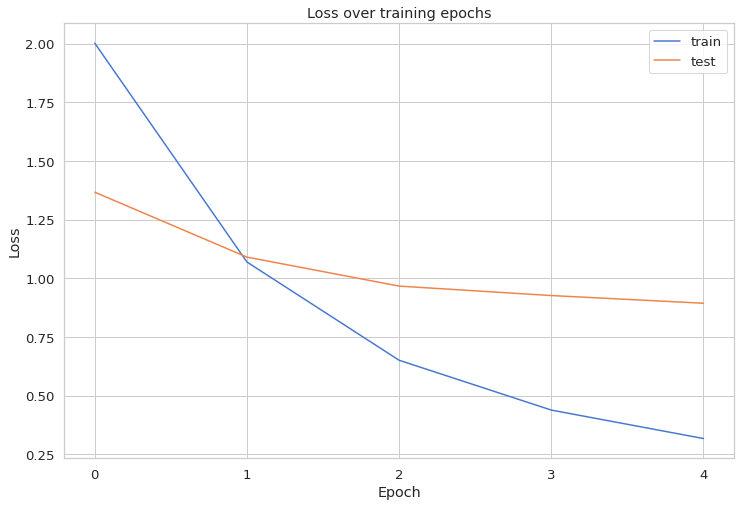

In [89]:
from matplotlib.ticker import MaxNLocator
#@title Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [116]:
predictions = model.predict(tf_validation_dataset)["logits"]

In [117]:
import numpy as np
compute_metrics(predictions, np.array(encoded_dataset['test']["path"]))

{'accuracy': 0.7341772151898734}

In [118]:
#@title Accuracy
# _, train_acc = model.evaluate(data.train_x, data.train_y)
# _, test_acc = model.evaluate(data.test_x, data.test_y)

# print("train acc", train_acc)
# print("test acc", test_acc)

model.evaluate(tf_validation_dataset)

10/10 [==============================] - 1s 111ms/step - loss: 0.8932


0.8932151198387146

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.argmax(predictions, axis=1)
y_pred

array([11,  4,  5, 12,  8,  8,  8,  2,  9,  5,  5,  4,  2,  2,  4,  2,  5,
        4,  7,  8,  4,  2,  6, 12,  5,  8,  5, 12,  4,  6,  4,  7,  6, 10,
        7,  6,  4,  4,  6,  1,  2,  2,  5,  8,  9,  6, 12,  6,  9,  5,  9,
        5,  7,  9,  2,  8,  5,  8,  1,  1,  1,  6, 12,  7, 11,  1,  1,  1,
       12,  8,  1, 11,  5, 12,  5,  8,  4,  8, 12])

In [120]:
y = np.concatenate([y for x, y in tf_validation_dataset], axis=0)
y

array([11,  4, 12, 12,  8,  9,  8,  2,  9,  5,  9,  4,  2,  2,  4,  8,  5,
        4,  2,  8,  4,  3,  6, 12,  5,  8,  5, 12,  4,  6,  4,  7,  6,  2,
        7,  3,  4,  4,  5,  5,  1,  4,  5,  8,  9,  6, 12,  6,  9,  5,  9,
        5,  7,  3,  8,  8,  5,  9,  1, 12,  4,  6, 12,  7, 11,  1,  1,  2,
        0,  8,  1,  2,  1, 12,  5,  8,  4,  8, 12])

In [121]:
categories_feature.names

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)']

In [122]:
categories_feature.int2str(12)

'Практика экспорта, оптовых продаж и сбыта бизнес-единиц (БЕ)'

In [123]:
#@title Classification report
print(classification_report(y, y_pred, target_names=categories_feature.names))

                                                                                       precision    recall  f1-score   support

                                                      Практика коммерческой логистики       0.00      0.00      0.00         1
                                                 Практика недропользования и экологии       0.50      0.67      0.57         6
              Практика поддержки региональных, розничных продаж и клиентского сервиса       0.38      0.43      0.40         7
                  Практика правового сопровождения закупок МТР и услуг общего профиля       0.00      0.00      0.00         3
Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом       1.00      0.83      0.91        12
                       Практика правового сопровождения операционной деятельности БРД       0.75      0.82      0.78        11
                        Практика правового сопровождения переработки и инфраструктуры       0.75      1.00    

/root/doc-classifier/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/doc-classifier/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/doc-classifier/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/doc-classifier/.venv/

In [124]:
cm = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cm, index=categories_feature.names, columns=categories_feature.names)

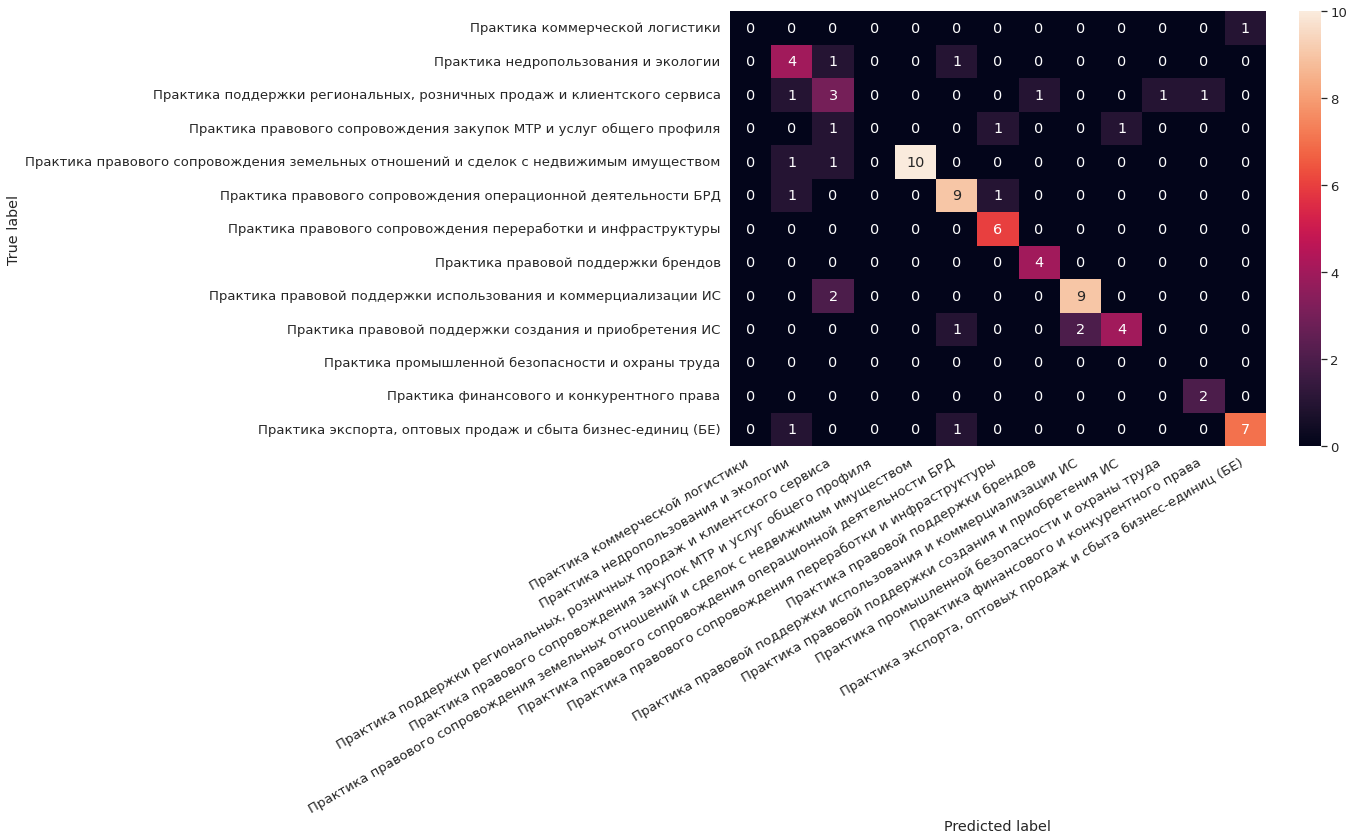

In [125]:
#@title Confusion matrix
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Predict

In [54]:
tf_validation_dataset

<PrefetchDataset shapes: ({attention_mask: (None, None), input_ids: (None, None)}, (None,)), types: ({attention_mask: tf.int64, input_ids: tf.int64}, tf.int64)>

In [37]:
text = '''
1.1. Заказчик поручает, а Исполнитель обязуется своими силами оказать Заказчику услуги по поиску, привлечению и отбору кандидатов, соответствующих требованиям Заказчика, на вакантные должности последнего на постоянную и временную работу на АЗС, более подробно описанные в Приложении № 1.
Услуги оказываются Исполнителем с __________________
1.2. По неисполненным денежным обязательствам договор действует до полного исполнения сторонами таких обязательств.
1.3. Отношения, возникающие по настоящему Договору, не являются трудовыми и регулируются исключительно гражданским законодательством. Исполнитель не включается в штат работников Заказчика, правила внутреннего трудового распорядка, утвержденные Заказчиком, на Исполнителя не распространяются. Исполнитель не получает прав, льгот и компенсаций, предусмотренных действующим трудовым законодательством для работников, выполняющих свою работу по трудовому договору (контракту). Заказчик не обязан осуществлять страхование Исполнителя от несчастного случая на производстве и профессиональных заболеваний.

'''
r = tokenizer(text, truncation=True, max_length=512)

In [38]:
r

{'input_ids': [1, 203, 21, 18, 21, 18, 5229, 340, 1445, 4935, 456, 16, 376, 37569, 540, 1986, 3238, 2924, 8296, 15236, 5229, 340, 15963, 12142, 341, 3475, 272, 16, 16113, 974, 289, 13116, 272, 18149, 16, 23478, 21846, 5229, 340, 5376, 16, 324, 18015, 892, 475, 9346, 7086, 324, 43824, 289, 642, 2705, 2852, 324, 448, 1229, 561, 16, 1027, 10921, 3265, 2592, 281, 26164, 370, 807, 331, 19846, 514, 18, 203, 1133, 486, 5088, 24689, 37569, 4152, 280, 225, 15680, 2414, 203, 21, 18, 22, 18, 945, 14664, 819, 268, 1760, 8221, 480, 20097, 338, 2986, 10123, 624, 11214, 16524, 36997, 2479, 20097, 18, 203, 21, 18, 23, 18, 1200, 19199, 16, 6764, 4275, 341, 28728, 20429, 272, 16, 332, 5291, 1566, 7972, 289, 15107, 33702, 6910, 2626, 1634, 35752, 18, 37569, 540, 332, 2617, 704, 281, 9644, 13095, 5229, 340, 5376, 16, 7879, 14437, 45505, 10821, 428, 16, 4707, 1209, 5229, 340, 8695, 16, 324, 37569, 1611, 332, 3894, 8891, 18, 37569, 540, 332, 10915, 720, 16, 28722, 289, 15907, 1971, 16, 49980, 43457, 1566, 3

In [39]:
predictions = model.predict([r['input_ids']])['logits']

In [40]:
predictions

array([[-0.73501086, -1.2939368 ,  4.1319013 ,  0.6204379 , -0.1843539 ,
        -1.0700302 , -1.2254825 ,  0.94197637, -1.2017342 , -1.3603083 ,
        -0.7224869 ,  0.7995952 ,  0.6095731 ]], dtype=float32)

In [41]:
predictions = np.argmax(predictions, axis=1)

In [42]:
predictions

array([2])

In [43]:
categories_feature.int2str(int(predictions[0]))

'Практика поддержки региональных, розничных продаж и клиентского сервиса'